In [1]:
# standard python utilities
import os
from os.path import join, basename,dirname
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

fig_dir = proj_dir+'/Streambed_seepage/figures/'
hob_dir = join(gwfm_dir, 'HOB_data')
sfr_dir = gwfm_dir+'/SFR_data/'

py_dir = doc_dir +'GitHub/CosumnesRiverRecharge/python_utilities/'



In [3]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
#     sys.path.append(flopy_dir)
    sys.path.insert(0, flopy_dir)
# sys.path
import flopy 

In [4]:
def gdf_bnds(gdf, ax, buf=1):
    gdf_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [gdf.unary_union.buffer(buf)], crs=gdf.crs)
    minx, miny, maxx, maxy = gdf_bnd.bounds.values[0]
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    return(gdf_bnd)



In [5]:
def get_layer_from_elev(elev, botm_slice, nlay):
    """  Return uppermost model layer occupied at least partly by some elevation data
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k + 1
    return(elev_lay.astype(int))

In [218]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

model_nam = 'inset_oneto_denier'
# model_nam = 'oneto_denier_homogeneous'
model_nam = 'oneto_denier_2014_2018'

model_ws = join(loadpth,model_nam)

# model_ws = join(loadpth,'parallel_oneto_denier','realization000')
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt',
                              load_only=load_only,
                              )



In [219]:
print('Quantiles: ',[0,0.5,0.6,0.75,1])
print('HK :',np.quantile(m.upw.hk.array,[0,0.5,0.6,0.75,1]))
print('VKA :',np.quantile(m.upw.vka.array,[0,0.5,0.6,0.75,1]))

Quantiles:  [0, 0.5, 0.6, 0.75, 1]
HK : [  0.56160003  16.69140053  32.82120132  81.21060181 345.6000061 ]
VKA : [  0.56160003   0.74839461   1.11835396   3.8010149  345.6000061 ]


In [220]:
# makes it easier to load if I save a set of outputs with alternate names
m_ver = '' # default no alternate output/input names
# m_ver = '_vka10'


In [9]:
model_grp = 'inset_oneto_denier'
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_grp,'rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [304]:
XSg = pd.read_csv(join(model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

drop_iseg = XSg[~XSg['Logger Location'].isna()].iseg.values
# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [306]:
sfr = m.sfr
sfrdf = pd.DataFrame(sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
# use facies of vka just below stream
vka_sfr = m.upw.vka.array[sfrdf.k, sfrdf.i, sfrdf.j]
vka_quants = pd.DataFrame(np.quantile(vka_sfr, tprogs_quants))
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[vka_sfr > vka_quants.iloc[n].values[0],'facies'] = vka_quants.index[n+1]
# remove stream segments for routing purposes only
grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]

In [11]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')


## Sensor data and XS data

In [12]:
rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))
rm_grid = gpd.GeoDataFrame(rm_grid, geometry = gpd.points_from_xy(rm_grid.Longitude,rm_grid.Latitude), 
                           crs='epsg:4326').to_crs(grid_p.crs)
# get model layer for heads
hob_row = rm_grid.row.values-1
hob_col = rm_grid.column.values-1

In [13]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')


In [15]:

# correspond XS to sensors
rm_elev = gpd.sjoin_nearest(XSg, rm_grid, how='right',lsuffix='xs', rsuffix='rm')
#MW_11, MW_CP1 had doubles with sjoin_nearest due to XS duplicates from Oneto_Denier
rm_elev = rm_elev.drop_duplicates(['xs_num','Sensor'])

## Model output - time variant

In [340]:
strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series((m.dis.nper-1)*15).astype('timedelta64[m]'))[0] # SS
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
hrs_from_strt = ((np.append([0], np.repeat(stplen, m.dis.nstp.array)[:-1])).cumsum()*24).astype('timedelta64[h]')
dates_stps = strt_date + hrs_from_strt


In [341]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper
# dt_ref

# Plot Groundwater Observed vs Simulated
We need to validate that the local model of Oneto-Denier is adequately representing stream-aquifer interactions so it can be used to quantify storage changes and particle age.

- field data shows fall lows around -2 to 2 m with peaks to 8m with winter
- simulated data shows fall lows around 3-5 meters with peaks to 8 m
- the simulated data as usual isn't showing as extreme reactions as the real data is showing which could be partly due to an issue with the initial steady state levels, the peaks match which means the stream stage is peaking close to reality. I may need to consider adding evapotranspiration as the GDEs are likely pulling water
- adding EVT and RCH together brought the steady state conditions to match observed conditions, but way over-estimated the winter peaks

In [224]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# extract time series of heads for each desired location
mw_hds = hdobj.get_ts(list(zip(rm_grid['lay'], hob_row, hob_col)))
mw_hds = pd.DataFrame(mw_hds, columns=['time']+rm_grid.Sensor.tolist())
# convert to hourly to maintain more precision in DT
mw_hds['dt'] = strt_date+(mw_hds.time.values*24 ).astype('timedelta64[h]')
mw_gwl = mw_hds.drop(columns=['time'])
# long format for id join with observed dat
mw_long = mw_gwl.melt(id_vars='dt', var_name='Well',value_name='sim')
mw_long = mw_long[mw_long.sim != -1e30]

In [225]:
mw_chk = mw_long.join(hobout.set_index(['Sensor','dt']), on=['Well','dt'], how='inner')
mw_chk = mw_chk.melt(id_vars=['dt', 'Well'],value_vars=['sim','obs_val'], value_name='gwe', var_name='type')


In [339]:
# sns.relplot(mw_chk,x='dt',y='gwe',col='Well', hue='type', col_wrap=4)

In [19]:
from sklearn.metrics import r2_score, mean_squared_error

def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

def clean_hob(model_ws):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
    hobout[['Sensor', 'spd']] = hobout.obs_nam.str.split('p',n=2, expand=True)
    hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout.loc[hobout.sim_val.isin([-1e30, -999.99]), 'sim_val'] = np.nan
    hobout = hobout.dropna(subset='sim_val')
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    
    return(hobout)


In [342]:
hobout = clean_hob(model_ws)

In [343]:
# summary stats by well
mw_stats = hobout[['Sensor','sq_error']].groupby('Sensor').sum()
mw_stats['r2'] = 0
for s in hobout.Sensor.unique():
    df_s = hobout[hobout.Sensor==s]
    mw_stats.loc[s,'r2'] = r2_score(df_s.obs_val, df_s.sim_val)
    mw_stats.loc[s,'RMSE'] = mean_squared_error(df_s.obs_val, df_s.sim_val, squared=True)
    mw_stats.loc[s,'NSE'] = nse(df_s.obs_val, df_s.sim_val)

t=0
sum_stats = pd.DataFrame(columns=['r2','RMSE','NSE'])
# summary statistics
sum_stats.loc[t,'r2'] = r2_score(hobout.obs_val, hobout.sim_val)
sum_stats.loc[t,'RMSE'] = np.sqrt(hobout.sq_error.sum()/len(hobout))
sum_stats.loc[t,'NSE'] = nse(hobout.obs_val, hobout.sim_val)

sum_stats

,r2,RMSE,NSE
0,-0.124433,3.151037,0.335991


In [344]:
hob_long = hobout.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe', var_name='type')
# hob_long

In [242]:
# chk_mw = ['MW_14','MW_CP1',]
# rm_grid.set_index('Sensor').loc[chk_mw]
# rm_grid[['Sensor','bot_screen', 'lay']].sort_values('bot_screen')

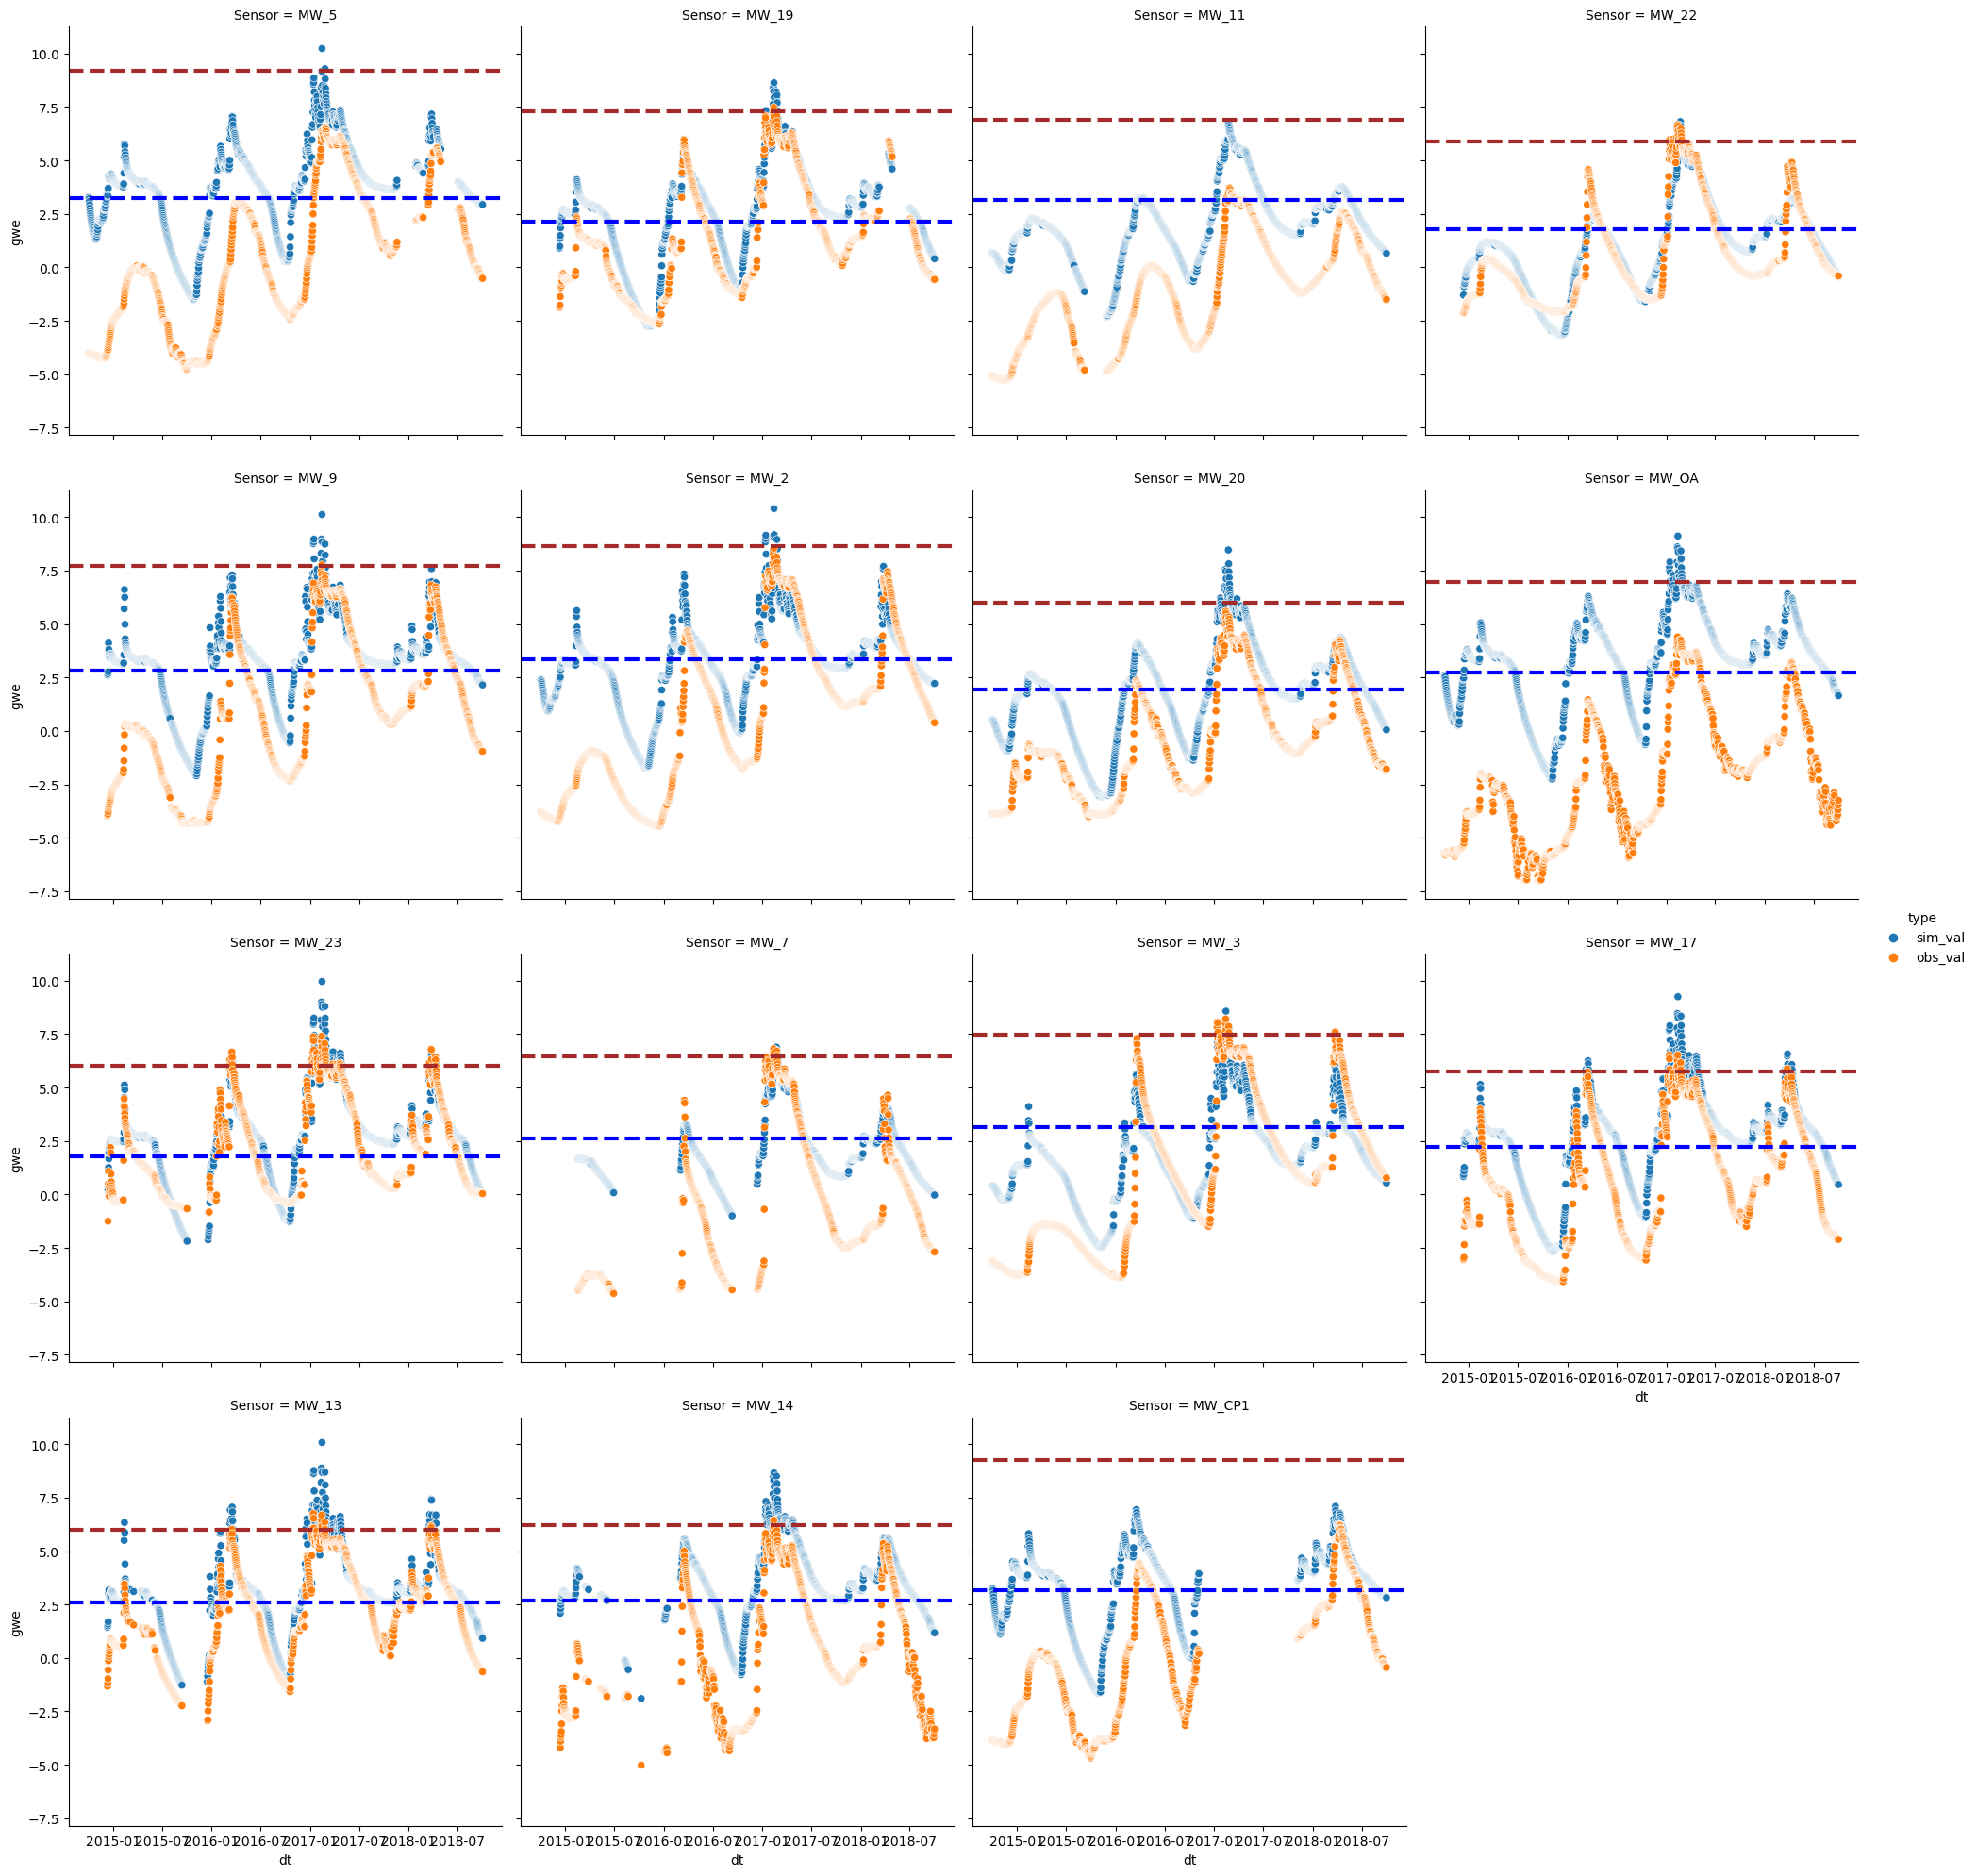

In [243]:
# hob_long, x='dt',y='
g = sns.relplot(hob_long, x='dt',y='gwe',col='Sensor',hue='type', col_wrap=4)

axes = g.axes.flatten()
mw = hob_long.Sensor.unique()

for n in np.arange(0,len(axes)):
    mw_dat = rm_elev[rm_elev.Sensor ==mw[n]]
    axes[n].axhline(mw_dat['MPE (meters)'].values[0], ls='--', linewidth=3, color='brown')
    axes[n].axhline(mw_dat['z_m_min_cln'].values[0]-1, ls='--', linewidth=3, color='blue')
#     axes[n].axhline(mw_dat['bot_screen_m'].values[0]-1, ls='--', linewidth=3, color='black')

In [345]:
# aggregate error for spatial plotting by month average?

hob_diff = hob_long.pivot_table(index=['dt','Sensor'],values='gwe',columns='type')
hob_diff['h_diff'] = hob_diff.sim_val - hob_diff.obs_val

hob_diff_mon = hob_diff.reset_index().set_index('dt').groupby('Sensor').resample('MS').mean()
hob_diff_mon = hob_diff_mon[['h_diff']].reset_index()
# hob_diff_mon

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_24552\3347723881.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hob_diff_mon = hob_diff.reset_index().set_index('dt').groupby('Sensor').resample('MS').mean()


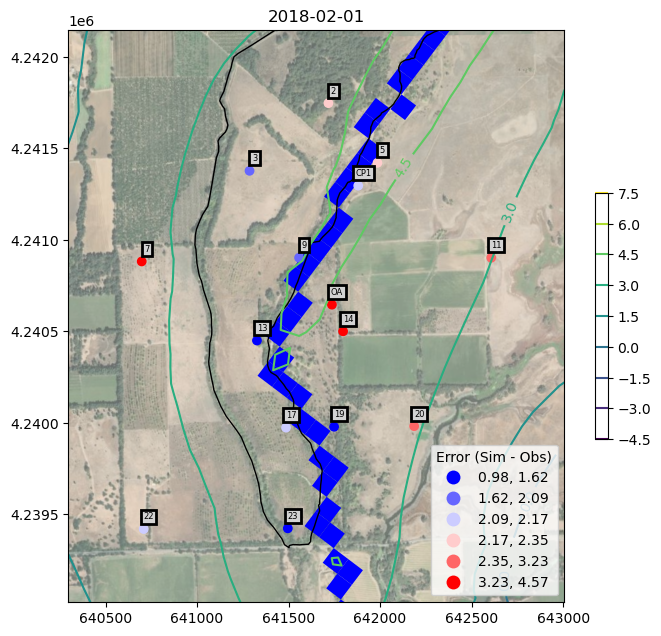

In [348]:
# t_plt = '2017-11-01'
# t_plt = '2018-06-01'
t_plt = '2018-02-01'

diff_plt = hob_diff_mon[hob_diff_mon.dt == t_plt]
# diff_plt['sign'] = np.sign(diff_plt.h_diff)
diff_plt = rm_grid.join(diff_plt.set_index('Sensor'),on='Sensor')

fig,ax=plt.subplots(figsize=(8, 8))
# m_domain.plot(ax=ax,color='None')
mapview = flopy.plot.PlotMapView(model=m,ax=ax)

gdf_bnd = gdf_bnds(rm_grid,buf=400,ax=ax)

spd = dt_ref[dt_ref.dt==t_plt].kstpkper.values[0]
avg_sfr_lay = int(np.round(grid_sfr.k.mean()))
head = hdobj.get_data((0,spd[-1]))[avg_sfr_lay] #m.dis.top.array - 
# head = np.ma.masked_where(head==-1e30, head)
head[head==-1e30] = np.nan
# m_domain.plot(ax=ax_n,color='none')
im = mapview.contour_array(head, masked_values=[-999.99, -1e30], ax=ax)
gdf_bnd = gdf_bnds(rm_grid,buf=400,ax=ax)

plt.colorbar(im, ax=ax, shrink = 0.4)
plt.clabel(im)

grid_sfr.plot(color='blue', ax=ax)
lak_extent.plot(color='none', ax=ax)
diff_plt.plot('h_diff', scheme='Quantiles', k = 6, ax=ax,
                  legend=True,cmap='bwr', legend_kwds={'loc':'lower right' ,'title':'Error (Sim - Obs)'})

rm_grid.apply(lambda x: ax.annotate(x.Sensor.replace('MW_',''), xy=x.geometry.coords[0], ha='center', fontsize=6,
                                    xytext = (5,10), textcoords='offset pixels',
#                                     arrowprops = {'shrink':1},
                                    bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=2)
                                                        ),axis=1);
ax.set_title(t_plt)

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.6)

In [32]:
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', parse_dates = ['DATE TIME'], index_col='DATE TIME')
mcc_d = mcc_d[(mcc_d.index>strt_date)&(mcc_d.index<end_date)]



In [ ]:
# load local stream stage data

## Lake plotting

In [227]:
# elevSteps, volArray, saArray
bathtxt = np.loadtxt(m.model_ws+'/MF.bath', delimiter = '\t')
bath = pd.DataFrame(bathtxt, columns=['elev','vol','area'])
# bath.plot(x='elev',y='vol')

In [349]:
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

def read_gage(gagenam):
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    strt_date = pd.to_datetime(m.dis.start_datetime)
    gage['dt'] = strt_date+(gage.Time*24).astype('timedelta64[h]')
    gage = gage.set_index('dt')
    gage['dVolume'] = gage.Volume.diff()
    gage['Total_In'] = gage[['Precip.','Runoff','GW-Inflw','SW-Inflw']].sum(axis=1)
    gage['Total_Out'] = gage[['Evap.','Withdrawal','GW-Outflw','SW-Outflw']].sum(axis=1)
    gage['In-Out'] = gage.Total_In - gage.Total_Out
#     gage['name'] = run
    return(gage)


In [350]:
lak_out = read_gage(join(model_ws, 'MF_lak.go'))

In [351]:
# model troubleshooting
# fig,ax = plt.subplots(4,1, sharex=True)
# lak_out.plot(y=['Total_In','Total_Out'], ax=ax[0])
# # plt.yscale('log')
# lak_out.plot(y=['In-Out','dVolume'],ax=ax[1])
# # (lak_out['In-Out']-lak_out.dVolume
# lak_out.plot(y='Volume',ax=ax[2])
# lak_out.plot(y=['Percent-Err'],ax=ax[-1])


<AxesSubplot: xlabel='dt'>

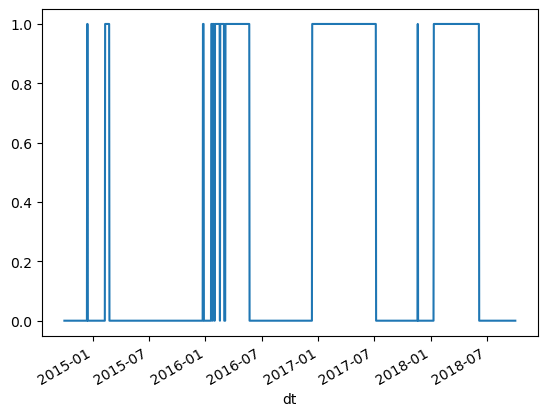

In [356]:
lak_out['2015-1-1':'2015-10-1']['Stage(H)'].min()
# min lake stage for lake out is 2.95
# outflow is zero in summer, stage is never 0, volume is zero in summer
# gw inflow is zero in 2015, 2016 summers
# np.sign(lak_out['SW-Outflw']).plot()

<AxesSubplot: xlabel='dt'>

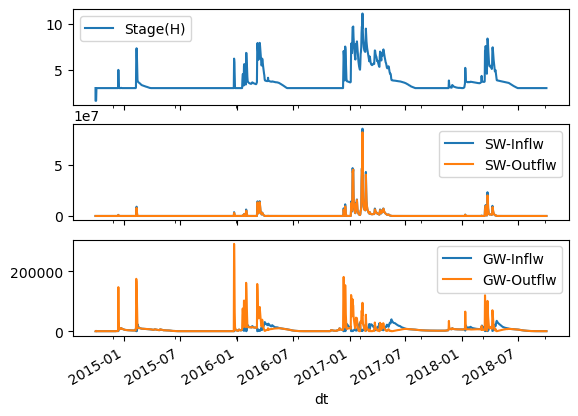

In [353]:
fig,ax = plt.subplots(3,1, sharex=True)
lak_out.plot(y=['Stage(H)'], ax = ax[0]) #dry all the time
# lak_out.columns # GW-Inflw, GW-Outflw, SW-Inflw, SW-Outflw
lak_out.plot(y=['GW-Inflw', 'GW-Outflw'], ax=ax[2]) # there is gw inflow
lak_out.plot(y=['SW-Inflw', 'SW-Outflw'], ax=ax[1]) # there is sw inflow


## SFR Plotting

In [318]:
# grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
# grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies']]
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']]-=1 # convert to python
    cmd2cfs = 1/((0.3048**3)*86400) # cubic meters per day to cfs
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # add column to track days with flow
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
#     sfrdf = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf['Qin_cfs'] = sfrdf.Qin * cmd2cfs
    sfrdf['Qout_cfs'] = sfrdf.Qout * cmd2cfs
    sfrdf['Qaquifer_cfs'] = sfrdf.Qaquifer * cmd2cfs
    
    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient == 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [354]:
sfrdf =  clean_sfr_df(model_ws)

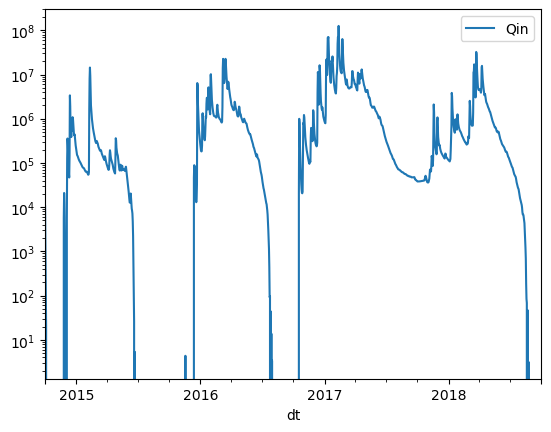

In [361]:
sfrdf[sfrdf.segment==52].plot(y='Qin')
plt.yscale('log')

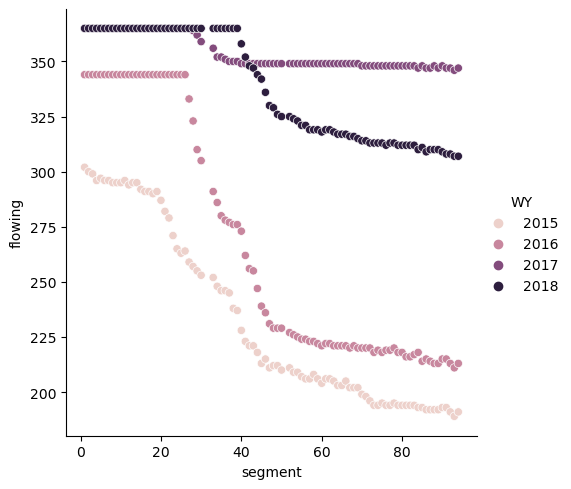

In [355]:
# find last day of flow

# start simple with just year by segment ,'month','facies'
sns.relplot(sfrdf.groupby(['WY','segment']).sum(numeric_only=True), x='segment',y='flowing', hue='WY')

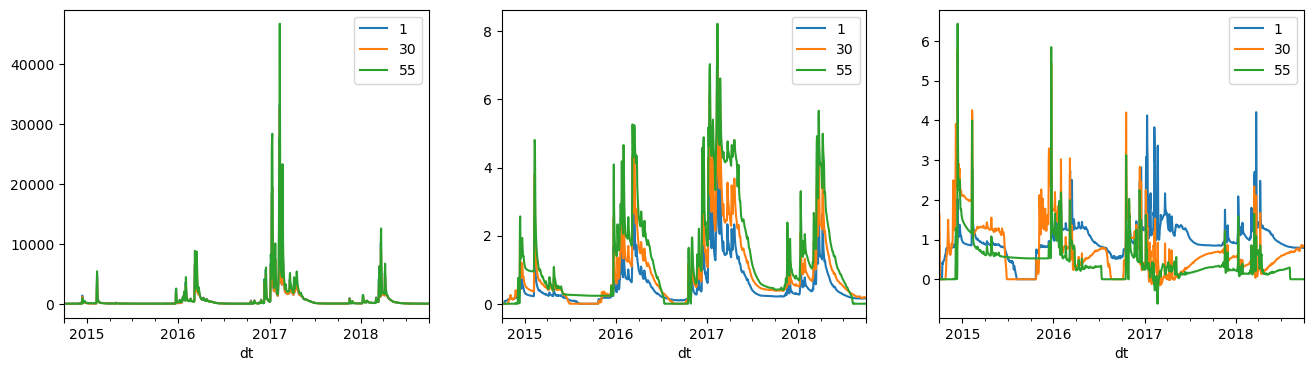

In [171]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
for s in [1,30,55]:
    sfrdf[sfrdf.segment==s].plot(y='Qout_cfs',ax=ax[0], label=s)
    sfrdf[sfrdf.segment==s].plot(y='depth',ax=ax[1], label=s)
    sfrdf[sfrdf.segment==s].plot(y='Qaquifer_cfs',ax=ax[2], label=s)


In [131]:
# sfrdf.groupby('segment').mean()['gradient'].plot()

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_24552\2268699019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_plt['num_coarse'] = x
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_24552\2268699019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_plt['year'] = y_plt.index.year


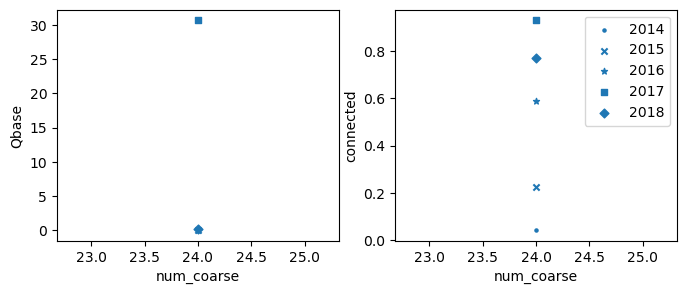

In [216]:

x = int(grid_sfr.facies.isin(['gravel','sand']).sum())
y = sfrdf[sfrdf.facies.isin(['gravel','sand'])].resample('AS').mean(numeric_only=True)
y_plt = y[['Qbase','connected']]
y_plt['num_coarse'] = x
y_plt['year'] = y_plt.index.year
y_sym = ['.','x','*','s', 'D']

fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].set_ylabel('Mean Annual Baseflow ($m^3/day$)')
ax[0].set_xlabel('Number of Coarse Stream Segments')    
ax[1].set_ylabel('Fraction of Time Connected')
ax[1].set_xlabel('Number of Coarse Stream Segments')
    
for n, yr in enumerate(y_plt.year):
    # ax[0].scatter(np.repeat(x, len(y1)), y1.Qbase.values)
    y_plt[y_plt.year==yr].plot.scatter('num_coarse','Qbase', ax=ax[0],  marker=y_sym[n])

    # ax[1].scatter(np.repeat(x, len(y1)), y1.connected.values)
    y_plt[y_plt.year==yr].plot.scatter('num_coarse','connected', ax=ax[1], marker=y_sym[n])


plt.legend(y_plt.year)

In [136]:
# grid_sfr[['iseg','ireach','facies']]
sfr_facies_sum = sfr_facies.groupby(['dt','facies']).sum(numeric_only=True)
sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)



The gaining/losing work I did with Stephen Maples shows periods of connection and disconnection and if we assume that the magnitude of stream stage is higher in the wet years then likely the groundwater system is losing in those years as well. What is likely true about floodplains is that the system is predominantly losing except during flood periods when there are more complex local scale gaining/losing conditions. 

What this work shows is that gravels/sands are more active during these extreme wet periods.

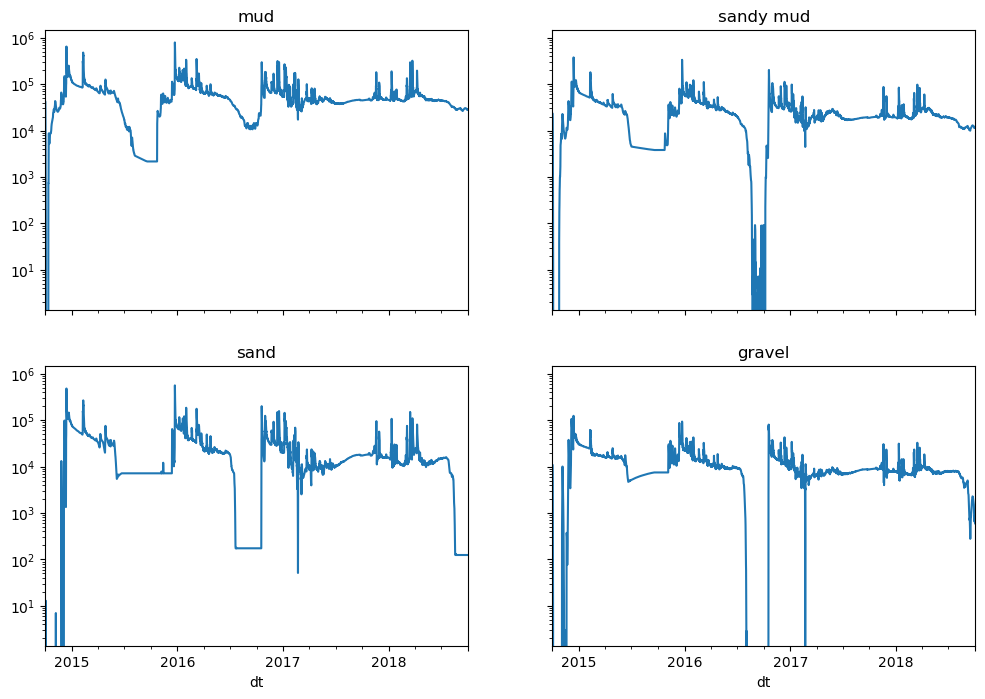

In [146]:
# som eissue with sharex is hiding mud probably issue of dt type, difference between mud and sandy mud
fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

df_rech= sfr_facies_sum[sfr_facies_sum.variable=='Qrech'].reset_index('facies')
for n, f in enumerate(['mud','sandy mud','sand','gravel']):
    ax_n = ax[int(n/2), n%2]
    df_plt = df_rech[df_rech.facies==f]
    df_plt.index = pd.to_datetime(df_plt.index)
    df_plt.plot(y='value', ax=ax_n, legend=False)
    ax_n.set_title(f)
    ax_n.set_yscale('log')

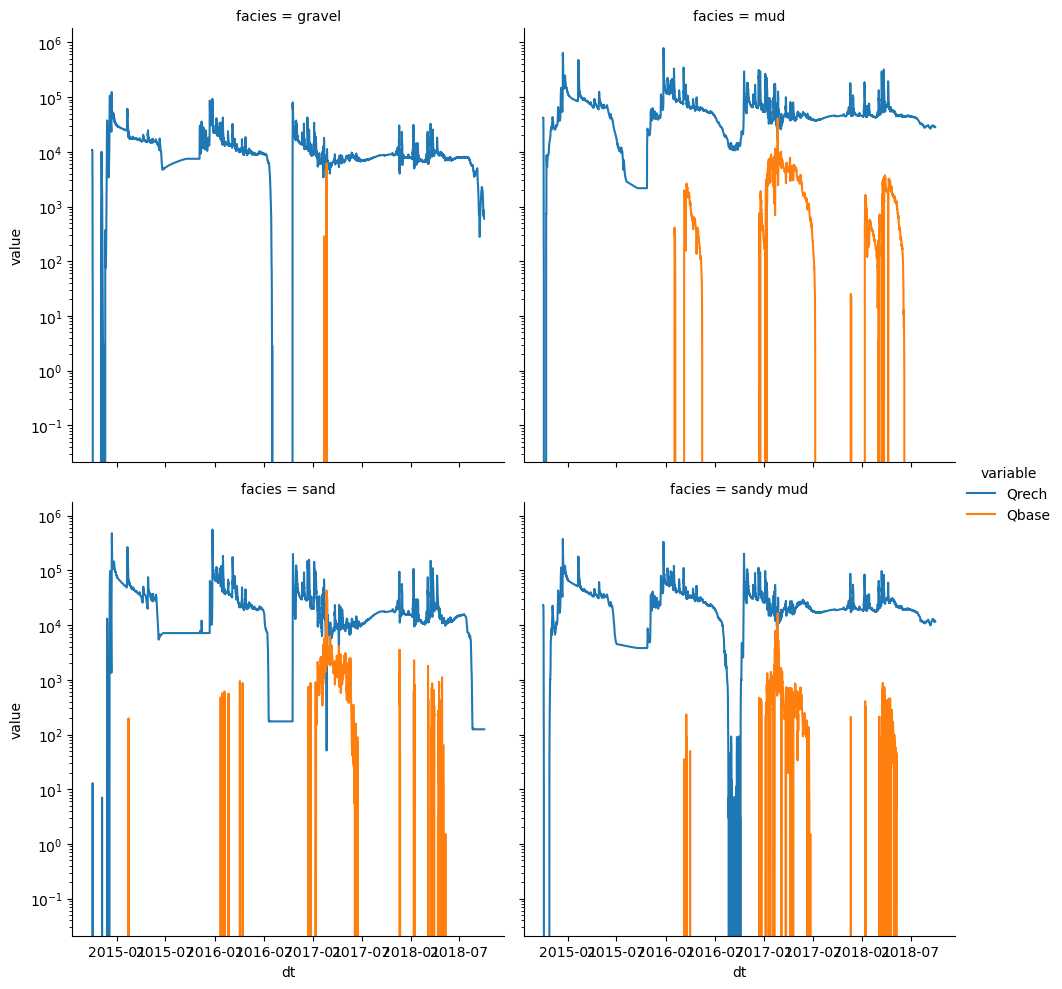

In [121]:
g = sns.relplot(sfr_facies_sum, x='dt',y='value',hue='variable', kind='line',
            col = 'facies', col_wrap=2)
g.set(yscale='log')

### Plot stream discretization

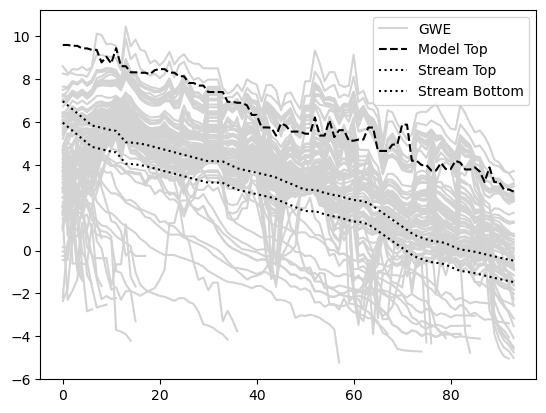

In [111]:

# spd_hd = dt_ref[dt_ref.dt == '2020-05-21'].kstpkper.values[0]
# head = hdobj.get_data(spd_hd)[0][0]

for t in spd_stp[0::90]: # every 7 days 
#     spd_hd = dt_ref[dt_ref.dt == t].kstpkper.values[0]
    head = hdobj.get_data(t)[grid_sfr.k, grid_sfr.i, grid_sfr.j]
    head = head[head!=-1e30]
    plt.plot(head, color='lightgray')
plt.plot(head,label = 'GWE',  color='lightgray')
plt.plot(m.dis.top.array[grid_sfr.i, grid_sfr.j], label='Model Top', ls='--',color='black')
plt.plot(m.sfr.reach_data.strtop, label= 'Stream Top', ls=':',color='black')
plt.plot(m.sfr.reach_data.strtop-m.sfr.reach_data.strthick, label= 'Stream Bottom', ls=':',color='black')

plt.legend()

## Grid wide head distribution

In [35]:
# sfr_gpd = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.row+1, grid_sfr.column+1))]

In [ ]:
avg_sfr_lay = int(np.round(grid_sfr.k.mean()))

nx = 2
ny = 8
fig,ax = plt.subplots(ny,nx, figsize=(12,12),sharex=True, sharey=True)

# fig.tight_layout()
for n,t in enumerate(spd_stp[::90][1:]):
    head = hdobj.get_data(t)[avg_sfr_lay] #m.dis.top.array - 
        
    ax_n = ax[int(n / ny), n % ny]
    mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
    m_domain.plot(ax=ax_n,color='none')
    im = mapview.contour_array(head, masked_values=[-999.99], ax=ax_n)
    grid_sfr.plot(ax=ax_n)
# vmin, vmax from visual inspection but could be added with code
#     im = ax_n.contour(head[avg_sfr_lay])

    ax_n.set_aspect(1)
    plt.colorbar(im, ax=ax_n, shrink = 0.4)
# fig.subplots_adjust(wspace=0.2, hspace=-.5)
fig.tight_layout()